In [27]:
import scipy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
from sklearn import linear_model, ensemble
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import Normalizer
%matplotlib inline

# Statistic Calculation Functions

In [2]:
def offensive_ratings(data):
    w_off_rating = 100 * data.Wscore / (0.5 * \
    ((data.Wfga + 0.4 * data.Wfta - 1.07 * (data.Wor / (data.Wor + data.Ldr)) * \
    (data.Wfga - data.Wfgm) + data.Wto) + (data.Lfga + 0.4 * data.Lfta - 1.07 * \
    (data.Lor / (data.Lor + data.Wdr)) * (data.Lfga - data.Lfgm) + data.Lto)))   
    l_off_rating = 100 * data.Lscore / (0.5 * \
    ((data.Lfga + 0.4 * data.Lfta - 1.07 * (data.Lor / (data.Lor + data.Wdr)) * \
    (data.Lfga - data.Lfgm) + data.Lto) + (data.Wfga + 0.4 * data.Wfta - 1.07 * \
    (data.Wor / (data.Wor + data.Ldr)) * (data.Wfga - data.Wfgm) + data.Wto)))   
    return w_off_rating, l_off_rating

def defensive_ratings(data):
    w_def_rating = data.Lscore * 100 / (0.96 * (data.Lfga - data.Lor + data.Lto + (0.44 * data.Lfta)))
    l_def_rating = data.Wscore * 100 / (0.96 * (data.Wfga - data.Wor + data.Wto + (0.44 * data.Wfta)))
    return w_def_rating, l_def_rating

# Data Import and Preprocessing

In [3]:
teams = pd.DataFrame.from_csv("Teams.csv").to_dict()["Team_Name"]
power_conference_teams = [
    'Boston College','Baylor','Illinois','Arizona','Alabama',
    'Clemson','Iowa St','Indiana','Arizona St','Arkansas',
    'Duke','Kansas','Iowa','California','Auburn',
    'Florida St','Kansas St','Maryland','UCLA','Florida',
    'Georgia Tech','Oklahoma','Michigan','Colorado','Georgia',
    'Louisville','Oklahoma St','Michigan St','Oregon','Kentucky',
    'Miami FL','TCU','Minnesota','Oregon St','LSU',
    'North Carolina','Texas','Nebraska','USC','Mississippi',
    'NC State','Texas Tech','Northwestern','Stanford','Mississippi St',
    'Pittsburgh','West Virginia','Ohio St','Utah','Missouri',
    'Syracuse','Penn St','Washington','South Carolina',
    'Virginia','Purdue','Washington St','Tennessee',
    'Virginia Tech','Rutgers','Texas A&M',
    'Wake Forest','Wisconsin','Vanderbilt', 'Notre Dame',
]
school_to_id = dict((v,k) for k,v in teams.items())

power_conference_ids = [school_to_id[school] for school in power_conference_teams]

In [4]:
tourney_res_df = pd.DataFrame.from_csv("TourneyDetailedResults.csv", index_col=["Season", "Daynum", "Wteam", "Lteam"])
tourney_res_df["Tourney"] = 1
reg_season_df = pd.DataFrame.from_csv("RegularSeasonDetailedResults.csv", index_col=["Season", "Daynum", "Wteam", "Lteam"])
reg_season_df["Tourney"] = 0
results_df = pd.concat([reg_season_df, tourney_res_df])
results_df["Welo"] = 1600
results_df["Lelo"] = 1600
results_df["Wres"] = 1
results_df["Lres"] = 0

STAT_COLUMNS = ["score", "res", "fgm", "fga", "fgm3", "fga3", "ftm", "fta", "or", "dr", "ast", "to", "stl", "blk", "pf", "elo"]
WINNER_COLUMNS = list(map(lambda c: "W" + c, STAT_COLUMNS)) 
LOSER_COLUMNS = list(map(lambda c: "L" + c, STAT_COLUMNS))

results_df["Worating"], results_df["Lorating"] = offensive_ratings(results_df[WINNER_COLUMNS + LOSER_COLUMNS])
results_df["Wdrating"], results_df["Ldrating"] = defensive_ratings(results_df[WINNER_COLUMNS + LOSER_COLUMNS])

results_df["Wfgp"] = results_df["Wfgm"] / results_df["Wfga"]
results_df["W3pp"] = results_df["Wfgm3"] / results_df["Wfga3"]
results_df["Wftp"] = results_df["Wftm"] / results_df["Wfta"]
results_df["Wftaperfga"] = results_df["Wfta"] / results_df["Wfga"]
results_df["Wtovp"] = 100 * results_df["Wto"] / (results_df["Wfga"] + 0.44 * results_df["Wfta"] + results_df["Wto"])
results_df["Wefgp"] = (results_df["Wfgm"] + 0.5 * results_df["Wfgm3"]) / results_df["Wfga"]

results_df["Lfgp"] = results_df["Lfgm"] / results_df["Lfga"]
results_df["L3pp"] = results_df["Lfgm3"] / results_df["Lfga3"]
results_df["Lftp"] = results_df["Lftm"] / results_df["Lfta"]
results_df["Lftaperfga"] = results_df["Lfta"] / results_df["Lfga"]
results_df["Ltovp"] = 100 * results_df["Lto"] / (results_df["Lfga"] + 0.44 * results_df["Lfta"] + results_df["Lto"])
results_df["Lefgp"] = (results_df["Lfgm"] + 0.5 * results_df["Lfgm3"]) / results_df["Lfga"]

WINNER_COLUMNS += ["Worating", "Wdrating", "Wfgp", "W3pp", "Wftp", "Wftaperfga", "Wtovp", "Wefgp"]
LOSER_COLUMNS += ["Lorating", "Ldrating", "Lfgp", "L3pp", "Lftp", "Lftaperfga", "Ltovp", "Lefgp"]
STAT_COLUMNS += ["orating", "drating", "fgp", "3pp", "ftp", "ftaperfga", "tovp", "efgp"]
results_df.sort_index(inplace=True)

## Elo Calculation

In [5]:
def update_elo(season, team, new_elo):
    team_elos[season][team].append(new_elo)

def get_elo(season, team):
    return team_elos[season][team][-1]

def calc_elo(win_team, lose_team, season):
    winner_rank = get_elo(season, win_team)
    loser_rank = get_elo(season, lose_team)
    
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100: k = 32
    elif winner_rank >= 2100 and winner_rank < 2400: k = 24
    else: k = 16
    
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff
    
    return new_winner_rank, new_loser_rank

In [6]:
def initialize_elos():
    return {season: {team: [1600] for team in teams.keys()} for season in range(2003, 2018)}

team_elos = initialize_elos()

for i, (index, game_data) in enumerate(results_df.iterrows()):
    season, Daynum, Wteam, Lteam = index
    results_df.loc[index, "Lelo"] = get_elo(season.year, Lteam)
    results_df.loc[index, "Welo"]  = get_elo(season.year, Wteam)
    new_WElo, new_LElo = calc_elo(Wteam, Lteam, season.year)
    update_elo(season.year, Lteam, new_LElo)
    update_elo(season.year, Wteam, new_WElo)

## Feature Generation

In [7]:
def update_stats(team, w_l, data_dict, stats, lookback=8):
    for stat in STAT_COLUMNS:
        stats[team][stat].append(data_dict[w_l + stat])
#         if len(stats[team][stat]) > lookback: stats[team][stat] = stats[team][stat][1:lookback+1]
    stats[team]['elo'] = [stats[team]['elo'][-1]]
    
def check_power_conference(team, features):
    if team in power_conference_ids: features.append(1)
    else: features.append(0)

Generates features by concatenating two feature vectors of each teams compiled stats. 

In [8]:
# left team beats right team - label is 1
# right team beats left team - label is 0
NUM_FEATURES = 50

train_data, test_data = np.zeros(NUM_FEATURES), np.zeros(NUM_FEATURES)
train_labels, test_labels = np.zeros(1), np.zeros(1)
compiled_stats = []

print(datetime.now())
for season in results_df.index.levels[0]:
    print('Compiling stats for {0}'.format(season))
    stats = {}
    season_df = results_df.loc[season]
    for i, ((day, Wteam, Lteam), data) in enumerate(season_df.iterrows()):
        data_dict = data.to_dict()
        if Wteam not in stats.keys(): stats[Wteam] = { stat: [] for stat in STAT_COLUMNS }
        if Lteam not in stats.keys(): stats[Lteam] = { stat: [] for stat in STAT_COLUMNS }
        if day > 60:
            Wteam_stats = stats[Wteam]
            Lteam_stats = stats[Lteam]
            Wteam_features = [np.mean(stat) for stat in Wteam_stats.values()]
            check_power_conference(Wteam, Wteam_features)
            Lteam_features = [np.mean(stat) for stat in Lteam_stats.values()]
            check_power_conference(Lteam, Lteam_features)
            if i % 2 == 0: feature, label = np.hstack((Wteam_features, Lteam_features)), 1
            else: feature, label = np.hstack((Lteam_features, Wteam_features)), 0 
            if data['Tourney'] == 0:
                train_data = np.vstack((train_data, feature))
                train_labels = np.vstack((train_labels, label))
            else:
                test_data = np.vstack((test_data, feature))
                test_labels = np.vstack((test_labels, label))
        if data['Tourney'] == 0: 
            update_stats(Wteam, 'W', data_dict, stats)
            update_stats(Lteam, 'L', data_dict, stats)
                
    compiled_stats.append(stats)
print(datetime.now())

train_data, test_data = train_data[1:], test_data[1:]
train_labels, test_labels = train_labels[1:], test_labels[1:]

2017-07-29 15:16:28.784153
Compiling stats for 2003-01-01 00:00:00
Compiling stats for 2004-01-01 00:00:00
Compiling stats for 2005-01-01 00:00:00
Compiling stats for 2006-01-01 00:00:00


/Users/kevin/anaconda3/envs/tensorflow/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kevin/anaconda3/envs/tensorflow/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Compiling stats for 2007-01-01 00:00:00
Compiling stats for 2008-01-01 00:00:00
Compiling stats for 2009-01-01 00:00:00
Compiling stats for 2010-01-01 00:00:00
Compiling stats for 2011-01-01 00:00:00
Compiling stats for 2012-01-01 00:00:00
Compiling stats for 2013-01-01 00:00:00
Compiling stats for 2014-01-01 00:00:00
Compiling stats for 2015-01-01 00:00:00
Compiling stats for 2016-01-01 00:00:00
Compiling stats for 2017-01-01 00:00:00
2017-07-29 15:20:38.524439


In [51]:
train_data, test_data = np.nan_to_num(train_data), np.nan_to_num(test_data)

normalizer = Normalizer()
normalizer.fit(np.nan_to_num(train_data))
norm_train_data = normalizer.transform(train_data)
norm_test_data = normalizer.transform(test_data)

Generates features by differencing the two feature vectors

In [52]:
# left team beats right team - label is 1
# right team beats left team - label is 0
NUM_FEATURES = 50

train_data, test_data = np.zeros(NUM_FEATURES), np.zeros(NUM_FEATURES)
train_labels, test_labels = np.zeros(1), np.zeros(1)
compiled_stats = []

print(datetime.now())
for season in results_df.index.levels[0]:
    print('Compiling stats for {0}'.format(season))
    stats = {}
    season_df = results_df.loc[season]
    for i, ((day, Wteam, Lteam), data) in enumerate(season_df.iterrows()):
        data_dict = data.to_dict()
        if Wteam not in stats.keys(): stats[Wteam] = { stat: [] for stat in STAT_COLUMNS }
        if Lteam not in stats.keys(): stats[Lteam] = { stat: [] for stat in STAT_COLUMNS }
        if day > 60:
            Wteam_stats = stats[Wteam]
            Lteam_stats = stats[Lteam]
            Wteam_features = [np.mean(stat) for stat in Wteam_stats.values()]
            check_power_conference(Wteam, Wteam_features)
            Lteam_features = [np.mean(stat) for stat in Lteam_stats.values()]
            check_power_conference(Lteam, Lteam_features)
            if i % 2 == 0: feature, label = np.hstack((Wteam_features, Lteam_features)), 1
            else: feature, label = np.hstack((Lteam_features, Wteam_features)), 0 
            if data['Tourney'] == 0:
                train_data = np.vstack((train_data, feature))
                train_labels = np.vstack((train_labels, label))
            else:
                test_data = np.vstack((test_data, feature))
                test_labels = np.vstack((test_labels, label))
        if data['Tourney'] == 0: 
            update_stats(Wteam, 'W', data_dict, stats)
            update_stats(Lteam, 'L', data_dict, stats)
                
    compiled_stats.append(stats)
print(datetime.now())

train_data, test_data = train_data[1:], test_data[1:]
train_labels, test_labels = train_labels[1:], test_labels[1:]

2017-07-30 17:59:23.377022
Compiling stats for 2003-01-01 00:00:00
Compiling stats for 2004-01-01 00:00:00


KeyboardInterrupt: 

# Model Testing

In [ ]:
def train_model(train_data, train_labels, test_data, test_labels, model):
    model.fit(train_data, train_labels)
    print("Train Accuracy: {0}".format(model.score(train_data, train_labels)))
    print("Test Accuracy: {0}".format(model.score(test_data, test_labels)))
    return model

In [38]:
train_data, test_data = np.nan_to_num(train_data), np.nan_to_num(test_data)
train_labels, test_labels = train_labels.reshape(train_labels.shape[0]), test_labels.reshape(test_labels.shape[0])
train_data, train_labels = shuffle(train_data, train_labels)
test_data, test_labels = shuffle(test_data, test_labels)

print('LR')
model_lr = linear_model.LogisticRegression()
model_lr = train_model(norm_train_data, train_labels, norm_test_data, test_labels, model_lr)

print('GBC')
model_gbc = ensemble.GradientBoostingClassifier()
model_gbc = train_model(norm_train_data, train_labels, norm_test_data, test_labels, model_gbc)

print('NN')
model_nn = MLPClassifier()
model_nn = train_model(norm_train_data, train_labels, norm_test_data, test_labels, model_nn)


LR
Train Accuracy: 0.5072351312809328
Test Accuracy: 0.4989059080962801
GBC
Train Accuracy: 0.5730014260548612
Test Accuracy: 0.487964989059081
NN
Train Accuracy: 0.5
Test Accuracy: 0.5010940919037199


## Train On All The Data

In [44]:
data = np.vstack((train_data, test_data))
labels = np.hstack((train_labels, test_labels))

model = linear_model.LogisticRegression()
model.fit(data, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Predictions

In [45]:
seeds = pd.DataFrame.from_csv("TourneySeeds.csv")
slots = pd.DataFrame.from_csv("TourneySlots.csv")
schoolToId = dict((v,k) for k,v in teams.items())

In [46]:
def stats(df, team_id, season, daynum, games=8):
    features = [np.mean(stat) for stat in compiled_stats[-1][team_id].values()]
    check_power_conference(team_id, features)
    return np.array(features)

def predictGame(team1, team2, season, daynum, model):
    team1Stats = stats(results_df, team1, season, daynum)
    team2Stats = stats(results_df, team2, season, daynum)
    
    gameFeatures = np.hstack((team1Stats, team2Stats)).reshape(1, NUM_FEATURES)
    return model.predict_proba(gameFeatures)
    
def getTourneyPredictions(season, lastDayOfSeason, model=model_lr):
    tourneyTeams = list(seeds.loc[season]['Team'])

    predictionsDict = {}

    for t1 in tourneyTeams:
        for t2 in tourneyTeams:
            if t1 >= t2: continue
            prediction = predictGame(t1, t2, season, lastDayOfSeason, model)
            predictionsDict[(t1, t2)] = prediction
    return predictionsDict

def get_prediction(predictions_dict, t1, t2):
    t1Id, t2Id = schoolToId[t1], schoolToId[t2]

    if t1Id < t2Id: 
        ts, pred = [t2, t1], predictions_dict[(t1Id, t2Id)]
    else: 
        ts, pred = [t1, t2], predictions_dict[(t2Id, t1Id)]
    winning_index = np.argmax(pred)
    probability = np.max(pred)
    return ts[winning_index], ts[~winning_index], probability

def print_prediction(winner, loser, probability):
    print('Predict {0} will beat {1} with probability {2}'.format(winner, loser, round(probability, 2)))

In [47]:
predictionsDict2017 = getTourneyPredictions("2017-01-01", 134, model=model_lr)

In [48]:
tourneyTeams2017 = list(seeds.loc["2017-01-01"]['Team'])

for t1 in tourneyTeams2017:
    for t2 in tourneyTeams2017:
        if t1 >= t2: continue
        winner, loser, probability = get_prediction(predictionsDict2017, teams[t1], teams[t2])
#         print_prediction(winner, loser, probability)
        

# 2017 Tournament Simulation

In [50]:
season_2017 = '2017-01-01'

brackets = ['W', 'X', 'Y', 'Z']
seeds_2017 = seeds.loc[season_2017]
seeds_dict = {row['Seed']: row['Team'] for row in seeds_2017.to_dict(orient='records')}
first_four = [('W11a', 'W11b'), ('W16a', 'W16b'), ('Y16a', 'Y16b'), ('Z11a', 'Z11b')]

print('First Four')
for (seed1, seed2) in first_four:
    team1 = seeds_dict[seed1]
    team2 = seeds_dict[seed2]
    winner, loser, probability = get_prediction(predictionsDict2017, teams[team1], teams[team2])
    print_prediction(winner, loser, probability)
    seeds_dict[seed1[:-1]] = school_to_id[winner]
    
final_four = {}
for bracket in brackets:
    print('Region: {0}'.format(bracket))
    
    print('Round of 64')
    round_of_64 = []
    for i in range(1, 9):
        team1 = seeds_dict['{0}{1:0=2d}'.format(bracket, i)]
        team2 = seeds_dict['{0}{1:0=2d}'.format(bracket, 17 - i)]
        winner, loser, probability = get_prediction(predictionsDict2017, teams[team1], teams[team2])
        print_prediction(winner, loser, probability)
        round_of_64.append((winner, loser))
    
    print('Round of 32')
    round_of_32 = []
    for i in range(0, 4):
        team1, _ = round_of_64[i]
        team2, _ = round_of_64[7-i]
        winner, loser, probability = get_prediction(predictionsDict2017, team1, team2)
        print_prediction(winner, loser, probability)
        round_of_32.append((winner, loser))
        
    print('Sweet 16')
    sweet_sixteen = []
    for i in range(0, 2):
        team1, _ = round_of_32[i]
        team2, _ = round_of_32[3-i]
        winner, loser, probability = get_prediction(predictionsDict2017, team1, team2)
        print_prediction(winner, loser, probability)
        sweet_sixteen.append((winner, loser))
        
    print('Elite 8')
    elite_eight = []
    for i in range(0, 1):
        team1, _ = sweet_sixteen[i]
        team2, _ = sweet_sixteen[1-i]
        winner, loser, probability = get_prediction(predictionsDict2017, team1, team2)
        print_prediction(winner, loser, probability)
        elite_eight.append((winner, loser))
    final_four[bracket] = elite_eight[0][0]

    
print('Final 4')

win_ff1, lose_ff1, probability_1 = get_prediction(predictionsDict2017, final_four['W'], final_four['X'])
win_ff2, lose_ff2, probability_2 = get_prediction(predictionsDict2017, final_four['Y'], final_four['Z'])

print_prediction(win_ff1, lose_ff1, probability_1)
print_prediction(win_ff2, lose_ff2, probability_2)

print("Championship")

champion, runner_up, probability = get_prediction(predictionsDict2017, win_ff1, win_ff2)
print_prediction(champion, runner_up, probability)

First Four
Predict USC will beat Providence with probability 1.0
Predict New Orleans will beat Mt St Mary's with probability 1.0
Predict UC Davis will beat NC Central with probability 1.0
Predict Wake Forest will beat Kansas St with probability 1.0
Region: W
Round of 64
Predict Villanova will beat New Orleans with probability 1.0
Predict Troy will beat Duke with probability 1.0
Predict New Mexico St will beat Baylor with probability 1.0
Predict Florida will beat ETSU with probability 1.0
Predict Virginia will beat UNC Wilmington with probability 1.0
Predict USC will beat SMU with probability 1.0
Predict South Carolina will beat Marquette with probability 1.0
Predict Wisconsin will beat Virginia Tech with probability 1.0
Round of 32
Predict Wisconsin will beat Villanova with probability 1.0
Predict Troy will beat South Carolina with probability 1.0
Predict USC will beat New Mexico St with probability 1.0
Predict Virginia will beat Florida with probability 1.0
Sweet 16
Predict Wisconsin 

# Analysis

## Interesting Elo Graph

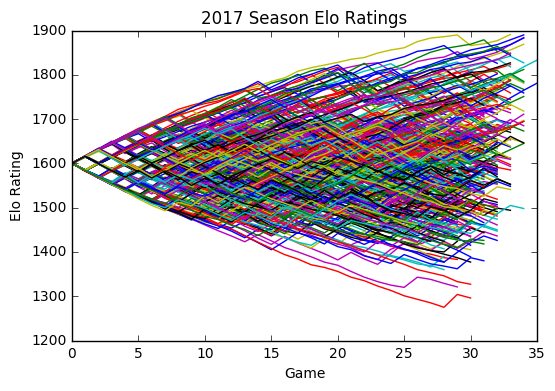

In [36]:
for i in range(len(list(team_elos[2017].values()))):
    plt.plot(list(team_elos[2017].values())[i])
plt.xlabel("Game")
plt.ylabel("Elo Rating")
plt.title("2017 Season Elo Ratings")

## PCA 

In [37]:
U, S, V = scipy.sparse.linalg.svds(data, 30)

<Container object of 3 artists>

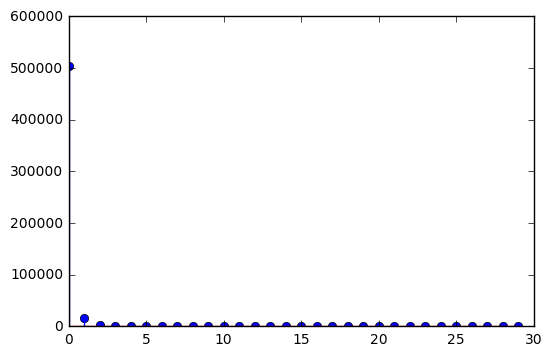

In [38]:
plt.stem(range(len(S)), S[::-1])

In [39]:
model_lr.coef_.shape

(1, 50)

# Keras Models

In [12]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=50))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

In [41]:
model.fit(norm_train_data, train_labels, epochs=10, batch_size=32)

Epoch 1/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.4988     
Epoch 2/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.4983     
Epoch 3/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.4996     
Epoch 4/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.5006     
Epoch 5/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.4989     
Epoch 6/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.4979     
Epoch 7/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.5001     
Epoch 8/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.4997     
Epoch 9/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.5007     
Epoch 10/10
47684/47684 [==============================] - 4s - loss: 0.6932 - acc: 0.4991     


In [43]:
model.predict(norm_test_data)

array([[ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0.50279742],
       [ 0

In [24]:
t = [l[0] for l in test_labels]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [32]:
np.nan_to_num(train_data)

array([[   2.27272727,   62.45454545,  105.18498848, ...,    0.36047238,
          22.7       ,    0.        ],
       [   2.5       ,   66.9       ,  109.54877261, ...,    0.34514729,
          19.75      ,    0.        ],
       [   5.        ,   72.2       ,   91.35099284, ...,    0.2783045 ,
          24.45454545,    0.        ],
       ..., 
       [   6.0625    ,   73.46875   ,  101.38097237, ...,    0.33126447,
          25.66666667,    0.        ],
       [   5.21212121,   75.03030303,   96.96481263, ...,    0.39129301,
          26.39393939,    0.        ],
       [   3.39393939,   76.24242424,  110.4165629 , ...,    0.36576923,
          23.23333333,    0.        ]])